# Pandemic Normalcy Index as Financial Factor

1. [Introduction](#intro)
2. [Data Analysis and Data Visualization](#eda)
3. [Normalcy Index vs the S&P500](#snp)


## Introduction<a class="anchor" id="intro"></a>
* Can the emergence of the Omicron variant explain the recent market drawdown?

In this notebook we use different "normalcy" features to construct a Covid-indicator and explore the connection between the indicator and the S&P500

**Detail**

use the Economist pandemic indicators to explain variations in the S&P500
* The Dataset "normalcy index" tracks how behavior has changed because of the pandemic. 
* The datasets tracks 8 daily-features, normalized to the pre-pandemic levels:
| Column name        | Description                                                                     | Weight | Source                                                                          |
| ------------------ | ------------------------------------------------------------------------------- | ------ | ------------------------------------------------------------------------------- |
| iso3c              | Country's iso3c code                                                            | NA     | NA                                                                              |
| date               | Date of data, yyyy-mm-dd                                                        | NA     | NA                                                                              |
| flights            | Flights departing domestic airports                                             | 0.1111 | UN ICAO                                                                         |
| public\_transport  | transport hubs of three largest cities, population-weighted average | 0.1111 | Google; Wind Data (for China)                                                   |
| traffic            | Congestion levels in three largest cities, population-weighted average          | 0.1111 | TomTom; Wind Data (for China)                                                   |
| cinema             | Box office revenues, local currency (weekly data)                               | 0.1111 | Box Office Mojo                                                                 |
| sports\_attendance | Attendance at professional sports events                                        | 0.1111 | Transfermarkt; afltables.com; hockey-reference.com; pro-football-reference.com; |
| time\_outside      | Time spent outside the home, country aggregate                                  | 0.1111 | Google; Economist estimate for China                                            |
| office\_occupancy  | Footfall in workplaces of three largest cities, population-weighted average     | 0.1666 | Google; Economist estimate for China                                            |
| retail\_footfall   | Footfall in "retail and recreation" sites, country aggregate                    | 0.1666 | Google; Economist estimate for China                                            |
| overall            | Weighted-average of 8 indicators above                                          | 1      | NA       

* The normalcy index is the weighted-average of these 8 indicators. 
* The S&P 500 is largely considered an essential benchmark index for the U.S. stock market. I used Yahoo Finance API to download the adjusted closed prices of the SPY ETF which tracks the S&P500. Interesting Finding.

**Summary**

No surprises, the S&P500 and the normalcy index are positively correlated. Presumably, the recent high-gradient negative changes in the index (caused by the Omicron variant) explain the recent market drawdown and volatility. The weekly changes in the indices are correlated as well.

Since the normalcy index is predictable at least in short horizons, this risk factor can be used to predict market's movements. What can I check next?

* Compare the "beta" of different stocks to this factor, for example comparing the index pandemic-resilience stocks (e.g. technology stocks) and pandemic-sensitive stocks
* Does the index have predictive power over oil prices? The market's PE ratio?

**Data sources**
* Economist data: https://www.economist.com/graphic-detail/tracking-the-return-to-normalcy-after-covid-19 Yahoo finance: https://finance.yahoo.com/ The data generated by * * The Economist are available under the Creative Commons Attribution 4.0 International License.


##### Import libraries

In [2]:
# install yahoo finance API
!pip install yfinance
!pip install yahoofinancials

  Created wheel for multitasking: filename=multitasking-0.0.10-py3-none-any.whl size=8500 sha256=a435fac06fec5aa81a1880788019452d6522ccdf11ad70adbc3cd46e80cc19f0
  Stored in directory: /Users/hila.dar/Library/Caches/pip/wheels/f2/b5/2c/59ba95dcf854e542944c75fe3da584e4e3833b319735a0546c
Successfully built multitasking
  Created wheel for yahoofinancials: filename=yahoofinancials-1.6-py3-none-any.whl size=15190 sha256=fe7a5c6231af916f318f9ca876b47433ea48293467c0f98f244f59ab21e0ce5a
  Stored in directory: /Users/hila.dar/Library/Caches/pip/wheels/7d/59/6e/ff5fc25443eef95656f84b7a3a421fa2a9d6eaaae7a1b7c08f
Successfully built yahoofinancials


In [109]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from datetime import datetime
sns.set(rc={'figure.figsize':(20,10)})

# yahoo finance:
import yfinance as yf
from yahoofinancials import YahooFinancials

# visualization settings
CMAP,fontfamily, context  = 'vlag',  "monospace", "notebook"
color_main = 'gold'
my_colors = [color_main, 'salmon', 'wheat', 'red']
rc = {'axes.titlesize':18, 'axes.titleweight':'bold',
      'axes.labelweight':'bold', 'figure.figsize':[12,8], 
      'lines.linewidth':5, 'axes.edgecolor':'black',
     'boxplot.boxprops.color': color_main}
sns.set(context=context, font=fontfamily, rc=rc, style="whitegrid")
sns.set_palette(CMAP)

#### Import data

The normalcy features were generated by The Economist and are available under the Creative Commons Attribution 4.0 International License. The data covers 50 countries across eight variables, and a population-weighted "world" aggregate of those 50 countries.

The market's performance data is from Yahoo Finance. I choosed the S&P500 total returns as a benchmark for the whole market performance. 

In [55]:
# import data
normalcy = pd.read_csv("normalcy-index.csv")
normalcy["date"] = pd.to_datetime(normalcy["date"])
normalcy = normalcy.set_index('date')

# import S&P data:
spy = yf.download('SPY', 
                      start='2020-01-01', 
                      progress=False,
)[["Adj Close"]]
spy.columns = ["price"]

print(f"normalcy df size={normalcy.shape}")
print(f"columns list={list(normalcy.columns)}")
normalcy.head()

normalcy df size=(36154, 10)
columns list=['iso3c', 'cinema', 'flights', 'office_occupancy', 'public_transport', 'retail_footfall', 'time_outside', 'sports_attendance', 'traffic', 'overall']


,iso3c,cinema,flights,office_occupancy,public_transport,retail_footfall,time_outside,sports_attendance,traffic,overall
date,,,,,,,,,,
2020-02-28,ARE,48.886518,96.943468,102.044649,98.573704,98.714286,99.000000,NaN,67.789476,89.043999
2020-02-29,ARE,51.289476,96.677830,102.187506,98.529055,98.857143,99.071429,NaN,67.851742,89.375824
2020-03-01,ARE,54.000001,96.507063,102.399564,98.435302,99.000000,99.071429,NaN,68.241294,89.796760
2020-03-02,ARE,57.018093,96.279374,102.611622,98.270120,99.071429,99.071429,NaN,67.658714,90.105206
2020-03-03,ARE,60.343752,95.994762,102.776803,97.962082,99.214286,99.071429,NaN,67.602677,90.497531


## Data Analysis and Data Visualization <a class="anchor" id="eda"></a>

#### simple data process

In [22]:
normalcy.head()

,iso3c,cinema,flights,office_occupancy,public_transport,retail_footfall,time_outside,sports_attendance,traffic,overall
date,,,,,,,,,,
2020-02-28,ARE,48.886518,96.943468,102.044649,98.573704,98.714286,99.000000,NaN,67.810152,89.046583
2020-02-29,ARE,51.289476,96.677830,102.187506,98.529055,98.857143,99.071429,NaN,67.872437,89.378410
2020-03-01,ARE,54.000001,96.507063,102.399564,98.435302,99.000000,99.071429,NaN,68.262108,89.799361
2020-03-02,ARE,57.018093,96.279374,102.611622,98.270120,99.071429,99.071429,NaN,67.679351,90.107785
2020-03-03,ARE,60.343752,95.994762,102.776803,97.962082,99.214286,99.071429,NaN,67.623297,90.500108


#### Visualize Features
* The features are pretty correalted.
* All of them dropped during the first wave, and slowly increase in 2020 with higher rate of increase after the vaccination. 
* All of the indicators have a sharpe decline in early 2022, due to the omicron wave. 

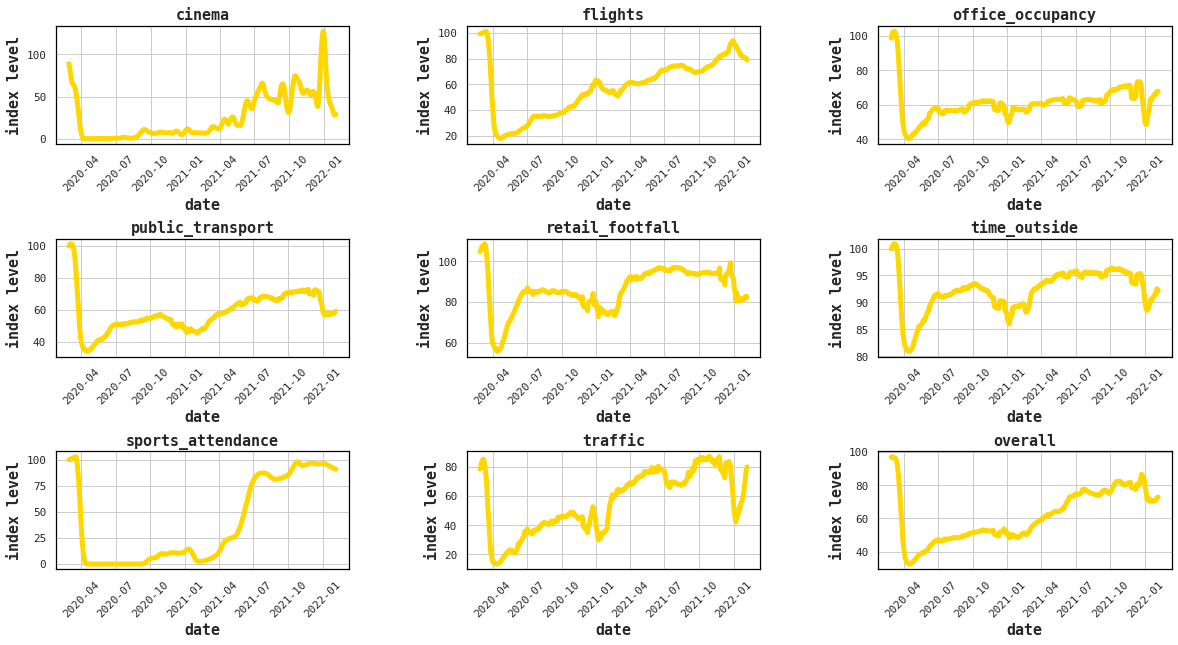

In [56]:
def plot_features(df, features, country=None, title = ""):
    fig = plt.figure(figsize=(20,10))
    fig.subplots_adjust(hspace=0.8, wspace=0.4)
    for i in np.arange(1, len(features)+1):
        ax = fig.add_subplot(3, len(features)//3, i)
        tmp = df
        if country:
            tmp = df[df["iso3c"]==country]        
        sns.lineplot(data=tmp, x =tmp.index , y = features[i-1],ax=ax, color =color_main,ci=None) 
        plt.xticks(rotation=45)
        ax.set_title(features[i-1], fontsize=15,weight = 'bold')
        plt.xlabel('date', fontsize = 15, weight = 'bold')
        plt.ylabel('index level', fontsize = 15, weight = 'bold')

    fig.savefig(f"./images/{title}.png")
    plt.show()
    
plot_features(normalcy,normalcy.select_dtypes(include=np.number).columns, "USA", "normalcy_features_usa")

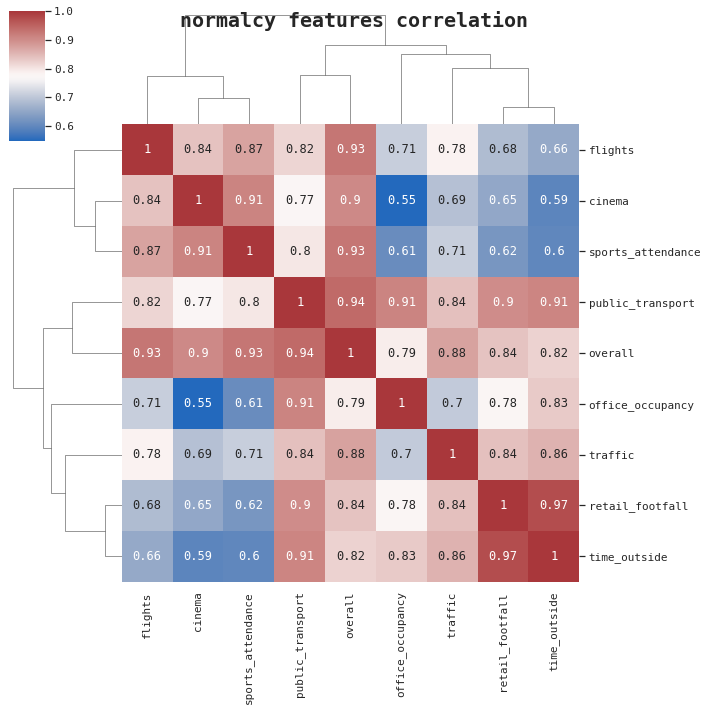

In [57]:
title = "normalcy features correlation"

g = sns.clustermap(data=normalcy[normalcy["iso3c"]=="USA"].corr(),annot=True,cmap="vlag")
g.fig.suptitle(title, fontsize=20,weight = 'bold') 
plt.savefig(f"./images/{title}.png")

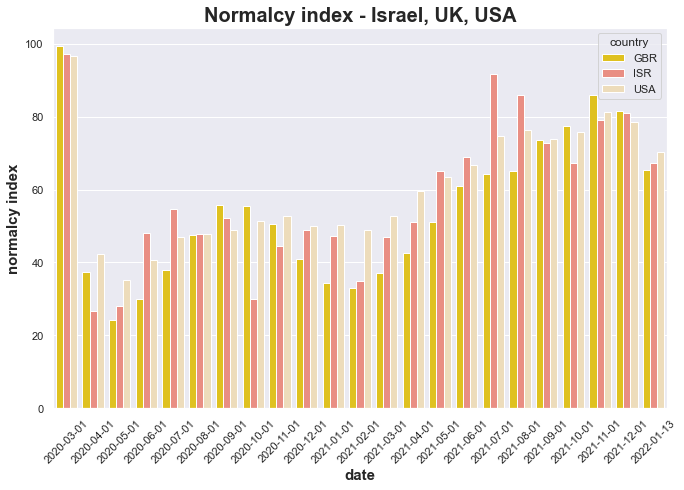

In [58]:
sns.set(rc={'figure.figsize':(11,7)})

countries = ["GBR", "USA", "ISR"]
dates = [datetime(year=2022, month=1, day=13)] + [datetime(year=2020+i, month=j, day=1) for i in range(2) for j in range(1,13)
        ]
tmp = normalcy[
    (normalcy["iso3c"].isin(countries)) &
    (normalcy.index.isin(dates))
][["overall",'iso3c' ]]
tmp.columns = ["normalcy_index", "country"]
tmp.index = tmp.index.map(lambda x:x.date())

fig, ax = plt.subplots()
sns.barplot(x=tmp.index, y="normalcy_index", hue="country", data=tmp, palette=my_colors[:3])
plt.xticks(rotation = 45)
title = "Normalcy index - Israel, UK, USA"
ax.set_title(title, fontsize=20)
plt.xlabel('date', fontsize = 15, weight = 'bold')
plt.ylabel('normalcy index', fontsize = 15, weight = 'bold')

fig.savefig(f"./images/{title}.png")

## Normalcy Index vs the S&P500 <a class="anchor" id="snp"></a>

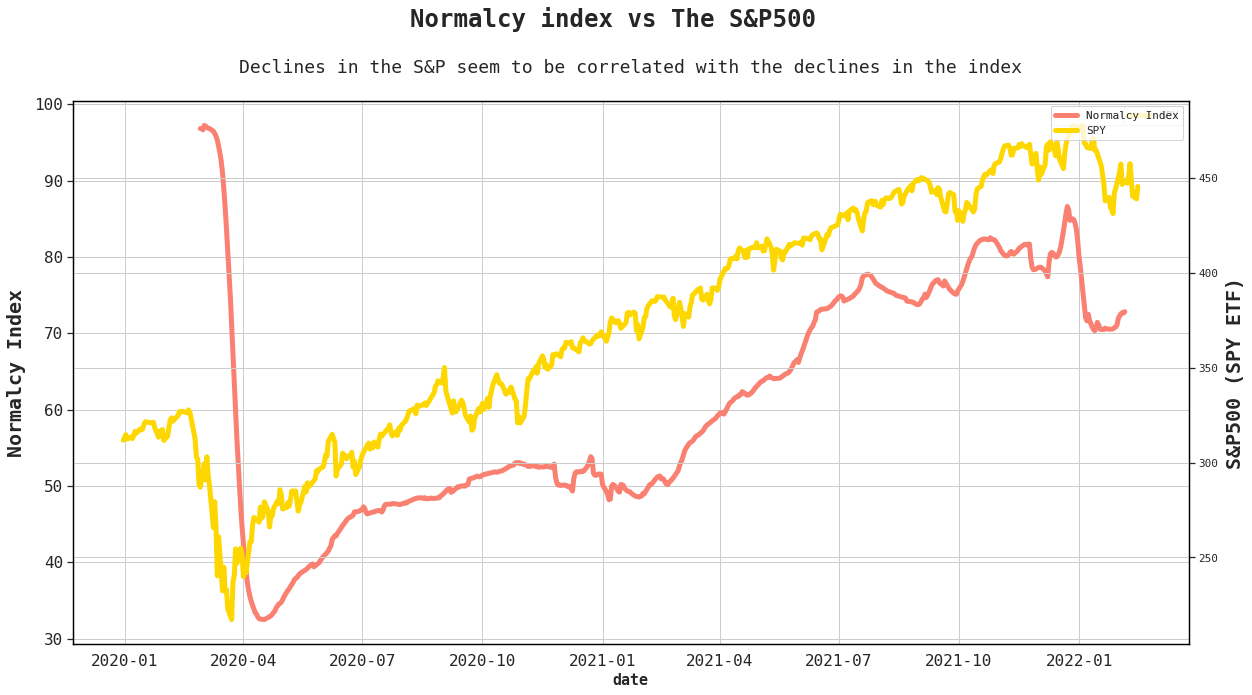

In [144]:
country = "USA"
title = "Normalcy index vs The S&P500"
subtitle = "Declines in the S&P seem to be correlated with the declines in the index"

col = "overall"
fig, ax = plt.subplots(figsize=(20,10))

# plot the normalcy index
sns.lineplot(data=normalcy[normalcy["iso3c"]==country], x=normalcy[normalcy["iso3c"]==country].index, y=col, label="Normalcy Index",ci=None, color="salmon")
plt.xlabel('date', fontsize = 15, weight = 'bold')
ax.set_ylabel("Normalcy Index", fontsize=20, labelpad=8,weight = 'bold')

# plot S&P data
ax2 =ax.twinx()
col = "price"
sns.lineplot(data=spy, x=spy.index, y=spy[col], label="SPY",ci=None, ax=ax2, color=color_main)

# plot settings
ax2.set_ylabel("S&P500 (SPY ETF)", fontsize=20, labelpad=8,weight = 'bold')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)

plt.suptitle(title, y=1.01, fontsize=24, weight="bold")
plt.title(subtitle, y=1.04, fontsize=18, weight="normal")

ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 16)
fig.savefig(f"./images/{title}.png")

Text(0.5, 1.04, 'the normalcy index explain high portion of the variation in the S&P only during waves')

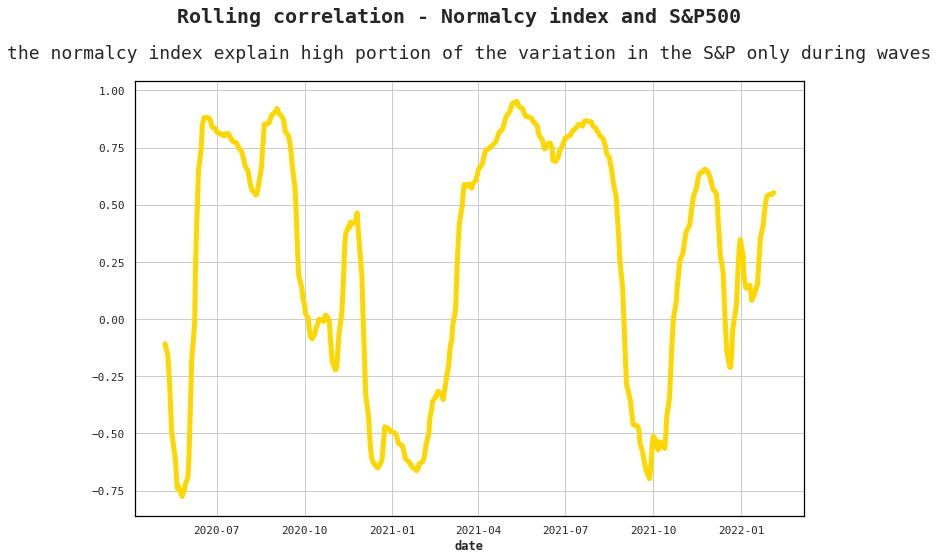

In [145]:
tmp = normalcy[normalcy["iso3c"]==country][["overall"]].reset_index().merge(spy, left_on="date", right_on="Date")
tmp = tmp.set_index('date')
title = "Rolling correlation - Normalcy index and S&P500"
subtitle = "the normalcy index explain high portion of the variation in the S&P only during waves"
ax = sns.lineplot(data=tmp["price"].rolling(50).corr(tmp["overall"]),color=color_main)
plt.suptitle(title, y=1.01, fontsize=20, weight="bold")
plt.title(subtitle, y=1.04, fontsize=18, weight="normal")